# Recognize MNIST Digit using Convolutional Network

https://www.kaggle.com/c/digit-recognizer

In [148]:
%matplotlib inline
import utils
reload(utils)
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape
from keras.models import Model, Sequential
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import utils;reload(utils)
utils.disable_scrolling()

# 32 dimensions encoded
input_shape = (1, 28, 28)
model = Sequential(name='encoder')
model.add(Reshape(input_shape, input_shape=(784,)))
model.add(Conv2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
model.add(Conv2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()
#model.load_weights('models/convolutional_recognizer_2.weights.h5')
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

<IPython.core.display.Javascript object>

autoscrolling long output is disabled
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_7 (Reshape)              (None, 1, 28, 28)     0           reshape_input_12[0][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 32, 28, 28)    320         reshape_7[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 32, 14, 14)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 32, 14, 14)    9248        maxpooling2d_13[0][0]            
_____________________________________________________

((42000, 784), (28000, 784))


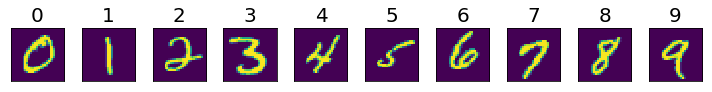

In [161]:
# regular MNIST dataset
data = utils.MNIST()
(X,Y) = data.get_ordered_sample()
utils.plot_array(X, titles=Y, cmap=None, limit=10)
mnist_train_batches = data.get_training_batches(batch_size=100)
mnist_test_batches = data.get_test_batches(batch_size=100)

# Competition data set
data = utils.MNIST_CSV()
X_train, Y_train = data.load_train()
competition_train_batches = utils.BatchIterator(X_train, utils.to_categorical(Y_train))
X_test = data.load_test()
print(X_train.shape, X_test.shape)

In [157]:
# Train on the original MNIST data set
model.fit_generator(mnist_train_batches, mnist_train_batches.N, 1, verbose=2, validation_data=mnist_test_batches, nb_val_samples=1000);

Epoch 1/1
117s - loss: 0.0366 - acc: 0.9875 - val_loss: 0.0248 - val_acc: 0.9907


In [158]:
# Test how we did
# Pretty accurate
N = 10000
loss, acc = model.test_on_batch(mnist_test_batches.x[:N], mnist_test_batches.y[:N])
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.01748, Accuracy: 0.99423


In [159]:
# Test current model with data for the competition
# Pretty accurate
N = 10000
loss, acc = model.test_on_batch(X_train[:N], utils.to_categorical(Y_train[:N]))
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.01800, Accuracy: 0.99433


In [162]:
# Train on Competition Data
model.fit_generator(competition_train_batches, competition_train_batches.N, 1, verbose=2,
                    validation_data=mnist_test_batches, nb_val_samples=100);

Epoch 1/1
37s - loss: 0.0190 - acc: 0.9936 - val_loss: 0.0252 - val_acc: 0.9900


(40, 10)


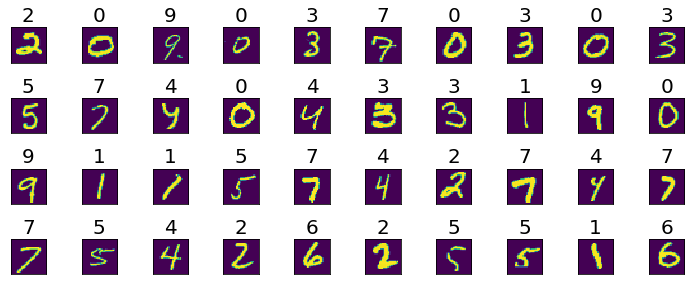

In [163]:
# Let's inspect some predictions
N=40
Y_test = recognizer.predict(X_test[:N])
print(Y_test.shape)
Y_test_cat = np.argmax(Y_test, axis=1)
utils.plot_array(X_test, Y_test_cat, limit=N)

In [164]:
# Generate a new training set that has shifted samples.  Shift them all around
from scipy.ndimage.interpolation import shift
N = 10
X_reshaped = X_train.reshape(X_train.shape[0],28,28)
print(X_train.shape)
X2_train = np.concatenate([
    X_reshaped,
    shift(X_reshaped, (0,-4,4)), #TL
    shift(X_reshaped, (0,+4,+4)),#TR
    shift(X_reshaped, (0,-4,-4)),#BL
    shift(X_reshaped, (0,-4,+4)),#BR
    shift(X_reshaped, (0,0,-4)), #L
    shift(X_reshaped, (0,0,+4)), #R
    shift(X_reshaped, (0,+4,0)), #T
    shift(X_reshaped, (0,-4,0)), #B
])
Y2_train = np.concatenate([Y_train for i in range(0,9)])
X2_train = X2_train.reshape(X2_train.shape[0], 784)
print(X2_train.shape, Y2_train.shape)
batches = utils.BatchIterator(X2_train, utils.to_categorical(Y2_train), batch_size=1000)

(42000, 784)
((378000, 784), (378000,))


In [166]:
# Train using shifted samples
model.fit_generator(batches, batches.N, 1, verbose=2, validation_data=batches, nb_val_samples=1000);

Epoch 1/1
350s - loss: 0.1526 - acc: 0.9455 - val_loss: 0.0639 - val_acc: 0.9793


In [169]:
loss, acc = model.test_on_batch(mnist_test_batches.x, mnist_test_batches.y)
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.15765, Accuracy: 0.93647


In [167]:
# create submission for the competition
Y_test = recognizer.predict(X_test)
Y_test_cat = np.argmax(Y_test, axis=1)
with open("submission.csv", "w") as fp:
    fp.write("ImageId,Label\n")
    for i in range(0,len(Y_test_cat)):
        fp.write("%s,%s\n" % (i+1, Y_test_cat[i]))
    fp.close()

In [168]:
utils.save_model(recognizer, "models/convolutional_recognizer_3")

Model saved: models/convolutional_recognizer_3.model.json
Weights saved: models/convolutional_recognizer_3.weights.h5
